### ---Public : 0.81600---
### Strong baseline : 0.81410
### ---Private : 0.80573---
### Medium baseline : 0.52807
### Simple baseline : 0.44862
<br>
解題思路:<br>
代補充<br>
<br>

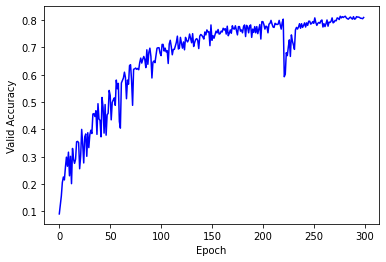

In [ ]:
!pip install transformers==4.5.0

In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from collections import Counter
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder, ImageFolder

# This is for the progress bar.
from tqdm import tqdm

from transformers import get_linear_schedule_with_warmup

import sys
sys.setrecursionlimit(1000000)

# the path where checkpoint saved
model_path = './model.ckpt'

myseed = 123  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.PILToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomErasing(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-10, 10, -10, 10))
])

train_flip_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.PILToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomErasing(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-10, 10, -10, 10))
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.PILToTensor(),
])

因為我是用強制標記，所以我沒有對unlabeled_set做圖形增強(image augmentation)

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32
test_batch_size = 1024

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../input/ml2021spring-hw3/food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
train_flip_set = DatasetFolder("../input/ml2021spring-hw3/food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_flip_tfm)
valid_set = DatasetFolder("../input/ml2021spring-hw3/food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_test_set = ImageFolder("../input/ml2021spring-hw3/food-11/training/unlabeled", loader=lambda x: Image.open(x), transform=test_tfm)
unlabeled_train_set = ImageFolder("../input/ml2021spring-hw3/food-11/training/unlabeled", loader=lambda x: Image.open(x), transform=train_tfm)
test_set = DatasetFolder("../input/ml2021spring-hw3/food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

train_set = ConcatDataset([train_set, train_flip_set])

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=test_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

In [ ]:
def get_pseudo_labels():
    global models, unlabeled_train_set, unlabeled_test_set, train_set
    
    remove_index, index = [], 0
    pre = []

    # Iterate over the dataset by batches.
    for imgs, labels in tqdm(unlabeled_test_set):
        imgs = imgs.float().cuda()
        for i, model in enumerate(models):
            model.eval()
            with torch.no_grad():
                logits = model(torch.unsqueeze(imgs, 0))
            prediction = torch.argmax(logits, 1)
            pre_num = prediction.cpu().numpy()
            pre.append(pre_num)
        arr = np.array(pre)
        pre.clear()
        result = [Counter(arr[:,i]).most_common(1)[0] for i in range(arr.shape[1])]
        
        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        if result[0][1] == model_number:
            temp = list(unlabeled_train_set[index])
            temp[1] = result[0][1]      
            train_set = ConcatDataset([train_set, ([tuple(temp)])])
            remove_index.append(index)
        index += 1
            
    remove_index.reverse()
    for i in remove_index:
        unlabeled_train_set.imgs.remove((unlabeled_train_set.imgs[i]))
        unlabeled_test_set.imgs.remove((unlabeled_test_set.imgs[i]))

    print(f"[{len(train_set)-3080*2}/6786] images have been labeled.")

我這邊的思路是當驗證集的acc高於0.7才去抓未標記的圖片<br>
然後當下一次的acc勝過之前的acc才會再做一次抓未標記的圖片的動作(你想想，如果你標記的圖片是對的，沒道理它的acc不會衝的比上一次更高)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.2)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.2)
        
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.dropout6 = nn.Dropout(0.2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1024, 11)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.dropout5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.dropout6(x)
        x = F.relu(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
# Initialize a model, and put it on the device specified.
#models = [Net().cuda() for i in range(model_number)]
model_number = 5
models = []

for i in range(model_number):
    model = torchvision.models.resnet34(pretrained = False)
    model.fc = nn.Linear(512, 11)
    models.append(model.cuda())

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# The number of training epochs.
n_epochs = 300

# Warm up
warm_up_ratio = 0.15
step = len(train_loader) + (6786*0.1//batch_size)
total_step = n_epochs * step

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.RAdam([{"params":model.parameters()} for model in models], lr=1e-3, weight_decay=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)

best_acc = 0
valid_acc_last = 0
valid_acc_threshold = 0.8

for epoch in range(n_epochs):
    
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if valid_acc_last > valid_acc_threshold:
        
        valid_acc_threshold = valid_acc_last
        
        # Obtain pseudo-labels for unlabeled data using trained model.
        if len(train_set) != 3080*2+6786: #3080*2+6786
            get_pseudo_labels()

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

    # ---------- Training ----------

    # Iterate the training set by batches.
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.float().cuda(), labels.cuda()
        optimizer.zero_grad()
        for model in models:
            model.train()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            
        # Update the parameters with computed gradients.
        optimizer.step()
        scheduler.step()

    # ---------- Validation ----------

    # These are used to record information in validation.
    pre = []
    vote_correct = 0
    models_correct = [0 for i in range(len(models))]

    # Iterate the validation set by batches.
    for imgs, labels in tqdm(valid_loader):
        imgs, labels = imgs.float().cuda(), labels.cuda()
        for i, model in enumerate(models):
            model.eval()
            with torch.no_grad():
                logits = model(imgs)
            prediction = torch.argmax(logits, 1)
            pre_num = prediction.cpu().numpy()
            models_correct[i] += (pre_num == labels.cpu().numpy()).sum()
            pre.append(pre_num)
        arr = np.array(pre)
        pre.clear()
        result = [Counter(arr[:,i]).most_common(1)[0][0] for i in range(arr.shape[1])]
        vote_correct += (result == labels.cpu().numpy()).sum()

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_acc = vote_correct/len(valid_set)
    valid_acc_last = valid_acc

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        for i, model in enumerate(models):
            torch.save(model.state_dict(), './model' + str(i) + '.ckpt')
        print('[{:03d}/{:03d}] saving model with acc {:.3f}'.format(epoch + 1, n_epochs, best_acc))

100%|██████████| 1/1 [00:12<00:00, 12.22s/it]


[ Valid | 001/300 ] acc = 0.09091
[001/300] saving model with acc 0.091


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


[ Valid | 002/300 ] acc = 0.12424
[002/300] saving model with acc 0.124


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 003/300 ] acc = 0.15606
[003/300] saving model with acc 0.156


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 004/300 ] acc = 0.20606
[004/300] saving model with acc 0.206


100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[ Valid | 005/300 ] acc = 0.22576
[005/300] saving model with acc 0.226


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 006/300 ] acc = 0.21515


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 007/300 ] acc = 0.26061
[007/300] saving model with acc 0.261


100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


[ Valid | 008/300 ] acc = 0.29848
[008/300] saving model with acc 0.298


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[ Valid | 009/300 ] acc = 0.26515


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 010/300 ] acc = 0.31667
[010/300] saving model with acc 0.317


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


[ Valid | 011/300 ] acc = 0.23030


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 012/300 ] acc = 0.30152


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 013/300 ] acc = 0.20152


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


[ Valid | 014/300 ] acc = 0.33030
[014/300] saving model with acc 0.330


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 015/300 ] acc = 0.29091


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


[ Valid | 016/300 ] acc = 0.27576


100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[ Valid | 017/300 ] acc = 0.29091


100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


[ Valid | 018/300 ] acc = 0.35455
[018/300] saving model with acc 0.355


100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


[ Valid | 019/300 ] acc = 0.35606
[019/300] saving model with acc 0.356


100%|██████████| 1/1 [00:07<00:00,  7.18s/it]


[ Valid | 020/300 ] acc = 0.35152


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 021/300 ] acc = 0.25606


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 022/300 ] acc = 0.30303


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


[ Valid | 023/300 ] acc = 0.40000
[023/300] saving model with acc 0.400


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 024/300 ] acc = 0.34545


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 025/300 ] acc = 0.27727


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 026/300 ] acc = 0.37273


100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


[ Valid | 027/300 ] acc = 0.38333


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


[ Valid | 028/300 ] acc = 0.30152


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


[ Valid | 029/300 ] acc = 0.38788


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 030/300 ] acc = 0.33333


100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


[ Valid | 031/300 ] acc = 0.38030


100%|██████████| 1/1 [00:06<00:00,  7.00s/it]


[ Valid | 032/300 ] acc = 0.39697


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


[ Valid | 033/300 ] acc = 0.38485


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 034/300 ] acc = 0.45606
[034/300] saving model with acc 0.456


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 035/300 ] acc = 0.45758
[035/300] saving model with acc 0.458


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


[ Valid | 036/300 ] acc = 0.44697


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 037/300 ] acc = 0.46818
[037/300] saving model with acc 0.468


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


[ Valid | 038/300 ] acc = 0.38182


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 039/300 ] acc = 0.49394
[039/300] saving model with acc 0.494


100%|██████████| 1/1 [00:07<00:00,  7.18s/it]


[ Valid | 040/300 ] acc = 0.43788


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


[ Valid | 041/300 ] acc = 0.43333


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 042/300 ] acc = 0.37273


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


[ Valid | 043/300 ] acc = 0.51667
[043/300] saving model with acc 0.517


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 044/300 ] acc = 0.48030


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


[ Valid | 045/300 ] acc = 0.38636


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[ Valid | 046/300 ] acc = 0.49091


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 047/300 ] acc = 0.37879


100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


[ Valid | 048/300 ] acc = 0.45303


100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


[ Valid | 049/300 ] acc = 0.45909


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 050/300 ] acc = 0.54242
[050/300] saving model with acc 0.542


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


[ Valid | 051/300 ] acc = 0.52424


100%|██████████| 1/1 [00:07<00:00,  7.00s/it]


[ Valid | 052/300 ] acc = 0.43485


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


[ Valid | 053/300 ] acc = 0.49848


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


[ Valid | 054/300 ] acc = 0.50758


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


[ Valid | 055/300 ] acc = 0.51515


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 056/300 ] acc = 0.48788


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 057/300 ] acc = 0.58030
[057/300] saving model with acc 0.580


100%|██████████| 1/1 [00:07<00:00,  7.81s/it]


[ Valid | 058/300 ] acc = 0.54848


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 059/300 ] acc = 0.56818


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


[ Valid | 060/300 ] acc = 0.42879


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


[ Valid | 061/300 ] acc = 0.40455


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 062/300 ] acc = 0.56970


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


[ Valid | 063/300 ] acc = 0.57879


100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


[ Valid | 064/300 ] acc = 0.58788
[064/300] saving model with acc 0.588


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


[ Valid | 065/300 ] acc = 0.60909
[065/300] saving model with acc 0.609


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 066/300 ] acc = 0.58939


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


[ Valid | 067/300 ] acc = 0.51212


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


[ Valid | 068/300 ] acc = 0.58030


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 069/300 ] acc = 0.56515


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 070/300 ] acc = 0.63333
[070/300] saving model with acc 0.633


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


[ Valid | 071/300 ] acc = 0.63636
[071/300] saving model with acc 0.636


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 072/300 ] acc = 0.57879


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


[ Valid | 073/300 ] acc = 0.48788


100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


[ Valid | 074/300 ] acc = 0.61970


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 075/300 ] acc = 0.62121


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


[ Valid | 076/300 ] acc = 0.62424


100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[ Valid | 077/300 ] acc = 0.61970


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 078/300 ] acc = 0.62273


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


[ Valid | 079/300 ] acc = 0.61818


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


[ Valid | 080/300 ] acc = 0.64394
[080/300] saving model with acc 0.644


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 081/300 ] acc = 0.66061
[081/300] saving model with acc 0.661


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


[ Valid | 082/300 ] acc = 0.64242


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 083/300 ] acc = 0.65606


100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


[ Valid | 084/300 ] acc = 0.66667
[084/300] saving model with acc 0.667


100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


[ Valid | 085/300 ] acc = 0.65606


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 086/300 ] acc = 0.62576


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


[ Valid | 087/300 ] acc = 0.69091
[087/300] saving model with acc 0.691


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 088/300 ] acc = 0.63788


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 089/300 ] acc = 0.68182


100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


[ Valid | 090/300 ] acc = 0.69697
[090/300] saving model with acc 0.697


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 091/300 ] acc = 0.66667


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


[ Valid | 092/300 ] acc = 0.58788


100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


[ Valid | 093/300 ] acc = 0.64545


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 094/300 ] acc = 0.65000


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


[ Valid | 095/300 ] acc = 0.64394


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 096/300 ] acc = 0.67121


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 097/300 ] acc = 0.69697


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 098/300 ] acc = 0.69848
[098/300] saving model with acc 0.698


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 099/300 ] acc = 0.69848


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 100/300 ] acc = 0.67879


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


[ Valid | 101/300 ] acc = 0.66970


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


[ Valid | 102/300 ] acc = 0.71061
[102/300] saving model with acc 0.711


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 103/300 ] acc = 0.71061


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 104/300 ] acc = 0.68636


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 105/300 ] acc = 0.69697


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 106/300 ] acc = 0.68333


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


[ Valid | 107/300 ] acc = 0.68788


100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


[ Valid | 108/300 ] acc = 0.64091


100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


[ Valid | 109/300 ] acc = 0.71212
[109/300] saving model with acc 0.712


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 110/300 ] acc = 0.72576
[110/300] saving model with acc 0.726


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


[ Valid | 111/300 ] acc = 0.70303


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 112/300 ] acc = 0.67273


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


[ Valid | 113/300 ] acc = 0.69242


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 114/300 ] acc = 0.69242


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 115/300 ] acc = 0.70455


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


[ Valid | 116/300 ] acc = 0.71818


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


[ Valid | 117/300 ] acc = 0.74091
[117/300] saving model with acc 0.741


100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


[ Valid | 118/300 ] acc = 0.69394


100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


[ Valid | 119/300 ] acc = 0.69697


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 120/300 ] acc = 0.73636


100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


[ Valid | 121/300 ] acc = 0.71515


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


[ Valid | 122/300 ] acc = 0.69697


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 123/300 ] acc = 0.71970


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


[ Valid | 124/300 ] acc = 0.69091


100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


[ Valid | 125/300 ] acc = 0.73636


100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


[ Valid | 126/300 ] acc = 0.72576


100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


[ Valid | 127/300 ] acc = 0.71970


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 128/300 ] acc = 0.72727


100%|██████████| 1/1 [00:07<00:00,  7.00s/it]


[ Valid | 129/300 ] acc = 0.74848
[129/300] saving model with acc 0.748


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 130/300 ] acc = 0.73182


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


[ Valid | 131/300 ] acc = 0.71667


100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


[ Valid | 132/300 ] acc = 0.75000
[132/300] saving model with acc 0.750


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


[ Valid | 133/300 ] acc = 0.70303


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


[ Valid | 134/300 ] acc = 0.71818


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 135/300 ] acc = 0.72879


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 136/300 ] acc = 0.73182


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 137/300 ] acc = 0.72576


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


[ Valid | 138/300 ] acc = 0.69545


100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


[ Valid | 139/300 ] acc = 0.74091


100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


[ Valid | 140/300 ] acc = 0.74697


100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


[ Valid | 141/300 ] acc = 0.74394


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 142/300 ] acc = 0.73788


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 143/300 ] acc = 0.73030


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


[ Valid | 144/300 ] acc = 0.75606
[144/300] saving model with acc 0.756


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 145/300 ] acc = 0.74545


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 146/300 ] acc = 0.76364
[146/300] saving model with acc 0.764


100%|██████████| 1/1 [00:08<00:00,  8.01s/it]


[ Valid | 147/300 ] acc = 0.75606


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 148/300 ] acc = 0.75758


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


[ Valid | 149/300 ] acc = 0.70606


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 150/300 ] acc = 0.78182
[150/300] saving model with acc 0.782


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


[ Valid | 151/300 ] acc = 0.72576


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[ Valid | 152/300 ] acc = 0.74242


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 153/300 ] acc = 0.73333


100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


[ Valid | 154/300 ] acc = 0.74697


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


[ Valid | 155/300 ] acc = 0.75909


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 156/300 ] acc = 0.75303


100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


[ Valid | 157/300 ] acc = 0.76515


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 158/300 ] acc = 0.74848


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 159/300 ] acc = 0.75000


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


[ Valid | 160/300 ] acc = 0.75909


100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


[ Valid | 161/300 ] acc = 0.75606


100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


[ Valid | 162/300 ] acc = 0.76970


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


[ Valid | 163/300 ] acc = 0.76364


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 164/300 ] acc = 0.76818


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 165/300 ] acc = 0.74848


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


[ Valid | 166/300 ] acc = 0.77727


100%|██████████| 1/1 [00:07<00:00,  7.81s/it]


[ Valid | 167/300 ] acc = 0.74242


100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


[ Valid | 168/300 ] acc = 0.75152


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


[ Valid | 169/300 ] acc = 0.76364


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 170/300 ] acc = 0.75152


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[ Valid | 171/300 ] acc = 0.77879


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


[ Valid | 172/300 ] acc = 0.76818


100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


[ Valid | 173/300 ] acc = 0.76667


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 174/300 ] acc = 0.77879


100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


[ Valid | 175/300 ] acc = 0.76212


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 176/300 ] acc = 0.74545


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 177/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


[ Valid | 178/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


[ Valid | 179/300 ] acc = 0.75909


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


[ Valid | 180/300 ] acc = 0.76364


100%|██████████| 1/1 [00:07<00:00,  7.55s/it]


[ Valid | 181/300 ] acc = 0.75303


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 182/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


[ Valid | 183/300 ] acc = 0.78182


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


[ Valid | 184/300 ] acc = 0.73939


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


[ Valid | 185/300 ] acc = 0.78030


100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


[ Valid | 186/300 ] acc = 0.77424


100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


[ Valid | 187/300 ] acc = 0.75303


100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


[ Valid | 188/300 ] acc = 0.77879


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 189/300 ] acc = 0.78182


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 190/300 ] acc = 0.73636


100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


[ Valid | 191/300 ] acc = 0.76667


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 192/300 ] acc = 0.75455


100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


[ Valid | 193/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 194/300 ] acc = 0.75303


100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


[ Valid | 195/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


[ Valid | 196/300 ] acc = 0.75000


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 197/300 ] acc = 0.76667


100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


[ Valid | 198/300 ] acc = 0.78333
[198/300] saving model with acc 0.783


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


[ Valid | 199/300 ] acc = 0.73030


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


[ Valid | 200/300 ] acc = 0.79394
[200/300] saving model with acc 0.794


100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


[ Valid | 201/300 ] acc = 0.79394


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


[ Valid | 202/300 ] acc = 0.78333


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 203/300 ] acc = 0.76667


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 204/300 ] acc = 0.77727


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


[ Valid | 205/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


[ Valid | 206/300 ] acc = 0.75303


100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


[ Valid | 207/300 ] acc = 0.78485


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 208/300 ] acc = 0.78788


100%|██████████| 1/1 [00:07<00:00,  7.57s/it]


[ Valid | 209/300 ] acc = 0.79848
[209/300] saving model with acc 0.798


100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


[ Valid | 210/300 ] acc = 0.78485


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


[ Valid | 211/300 ] acc = 0.77424


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 212/300 ] acc = 0.77273


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[ Valid | 213/300 ] acc = 0.78788


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 214/300 ] acc = 0.78485


100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


[ Valid | 215/300 ] acc = 0.78333


100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


[ Valid | 216/300 ] acc = 0.78485


100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


[ Valid | 217/300 ] acc = 0.79848


100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


[ Valid | 218/300 ] acc = 0.78333


100%|██████████| 1/1 [00:07<00:00,  7.60s/it]


[ Valid | 219/300 ] acc = 0.76667


100%|██████████| 1/1 [00:07<00:00,  7.18s/it]


[ Valid | 220/300 ] acc = 0.79091


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


[ Valid | 221/300 ] acc = 0.80303
[221/300] saving model with acc 0.803


100%|██████████| 6786/6786 [09:18<00:00, 12.15it/s]


[4124/6786] images have been labeled.


100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


[ Valid | 222/300 ] acc = 0.59242


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


[ Valid | 223/300 ] acc = 0.60152


100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


[ Valid | 224/300 ] acc = 0.68030


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


[ Valid | 225/300 ] acc = 0.66970


100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


[ Valid | 226/300 ] acc = 0.70152


100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


[ Valid | 227/300 ] acc = 0.72727


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 228/300 ] acc = 0.66667


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 229/300 ] acc = 0.74545


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


[ Valid | 230/300 ] acc = 0.72273


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


[ Valid | 231/300 ] acc = 0.70909


100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


[ Valid | 232/300 ] acc = 0.69242


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


[ Valid | 233/300 ] acc = 0.76364


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 234/300 ] acc = 0.77273


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 235/300 ] acc = 0.76667


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


[ Valid | 236/300 ] acc = 0.77424


100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


[ Valid | 237/300 ] acc = 0.78636


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 238/300 ] acc = 0.76970


100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


[ Valid | 239/300 ] acc = 0.78636


100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[ Valid | 240/300 ] acc = 0.77273


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 241/300 ] acc = 0.78030


100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


[ Valid | 242/300 ] acc = 0.78939


100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


[ Valid | 243/300 ] acc = 0.77424


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


[ Valid | 244/300 ] acc = 0.78939


100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


[ Valid | 245/300 ] acc = 0.78030


100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


[ Valid | 246/300 ] acc = 0.79545


100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


[ Valid | 247/300 ] acc = 0.79545


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


[ Valid | 248/300 ] acc = 0.78485


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


[ Valid | 249/300 ] acc = 0.78788


100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


[ Valid | 250/300 ] acc = 0.79394


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 251/300 ] acc = 0.78788


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 252/300 ] acc = 0.80758
[252/300] saving model with acc 0.808


100%|██████████| 2662/2662 [03:05<00:00, 14.32it/s]


[4701/6786] images have been labeled.


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


[ Valid | 253/300 ] acc = 0.79091


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


[ Valid | 254/300 ] acc = 0.78030


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


[ Valid | 255/300 ] acc = 0.78788


100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


[ Valid | 256/300 ] acc = 0.79091


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


[ Valid | 257/300 ] acc = 0.78788


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


[ Valid | 258/300 ] acc = 0.79697


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


[ Valid | 259/300 ] acc = 0.80000


100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


[ Valid | 260/300 ] acc = 0.77424


100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


[ Valid | 261/300 ] acc = 0.78636


100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


[ Valid | 262/300 ] acc = 0.77576


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


[ Valid | 263/300 ] acc = 0.78636


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


[ Valid | 264/300 ] acc = 0.80000


100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


[ Valid | 265/300 ] acc = 0.77727


100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[ Valid | 266/300 ] acc = 0.79242


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


[ Valid | 267/300 ] acc = 0.79091


100%|██████████| 1/1 [00:08<00:00,  8.16s/it]


[ Valid | 268/300 ] acc = 0.79545


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


[ Valid | 269/300 ] acc = 0.80758


100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


[ Valid | 270/300 ] acc = 0.78939


100%|██████████| 1/1 [00:08<00:00,  8.75s/it]


[ Valid | 271/300 ] acc = 0.79242


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


[ Valid | 272/300 ] acc = 0.79848


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


[ Valid | 273/300 ] acc = 0.79697


100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


[ Valid | 274/300 ] acc = 0.80758


100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


[ Valid | 275/300 ] acc = 0.80606


100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


[ Valid | 276/300 ] acc = 0.80152


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 277/300 ] acc = 0.81364
[277/300] saving model with acc 0.814


100%|██████████| 2085/2085 [02:24<00:00, 14.39it/s]


[4996/6786] images have been labeled.


100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[ Valid | 278/300 ] acc = 0.80758


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


[ Valid | 279/300 ] acc = 0.81212


100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


[ Valid | 280/300 ] acc = 0.80909


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


[ Valid | 281/300 ] acc = 0.81212


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


[ Valid | 282/300 ] acc = 0.81364


100%|██████████| 1/1 [00:07<00:00,  7.00s/it]


[ Valid | 283/300 ] acc = 0.80758


100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


[ Valid | 284/300 ] acc = 0.80455


100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


[ Valid | 285/300 ] acc = 0.80303


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


[ Valid | 286/300 ] acc = 0.80758


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


[ Valid | 287/300 ] acc = 0.81061


100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


[ Valid | 288/300 ] acc = 0.80606


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


[ Valid | 289/300 ] acc = 0.80303


100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


[ Valid | 290/300 ] acc = 0.81212


100%|██████████| 1/1 [00:06<00:00,  7.00s/it]


[ Valid | 291/300 ] acc = 0.80303


100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


[ Valid | 292/300 ] acc = 0.80455


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 293/300 ] acc = 0.81212


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


[ Valid | 294/300 ] acc = 0.81061


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[ Valid | 295/300 ] acc = 0.81061


100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


[ Valid | 296/300 ] acc = 0.80909


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


[ Valid | 297/300 ] acc = 0.80606


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


[ Valid | 298/300 ] acc = 0.80606


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


[ Valid | 299/300 ] acc = 0.80455


100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

[ Valid | 300/300 ] acc = 0.80909


In [ ]:
for i, model in enumerate(models):
    model.load_state_dict(torch.load('./model' + str(i) + '.ckpt'))

predictions = []

# Iterate the testing set by batches.
for imgs, labels in tqdm(test_loader):
    imgs = imgs.float().cuda()
    for i, model in enumerate(models):
        model.eval()
        with torch.no_grad():
            logits = model(imgs)
        prediction = torch.argmax(logits, 1)
        pre.append(prediction.cpu().numpy())
    arr = np.array(pre)
    pre.clear()
    result = [Counter(arr[:,i]).most_common(1)[0][0] for i in range(arr.shape[1])]
    predictions.extend(result)

100%|██████████| 4/4 [00:57<00:00, 14.44s/it]


In [ ]:
# Save predictions into the file.
with open("submission.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")